In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

data = pd.read_csv('logs/bo_runs_data_swing_Vext_diff_densB_addfeatchempT.csv')
doto = pd.read_csv('logs/gp_summary_data_swing_Vext_diff_densB_addfeatchempT.csv', on_bad_lines='skip')

In [ ]:
files_gp = glob.glob('logs/gp_summary_data_swing*.csv')
files_bo = glob.glob('logs/bo_runs_data_swing*.csv')

counts = data['found_global_best'].value_counts() # aus BO dateien


target_states = [
    {"temperature_kelvin_1": 298.0, "temperature_kelvin_2": 400.0, "pressure_bar_1": 1, "pressure_bar_2":1},
    {"temperature_kelvin_1": 298.0, "temperature_kelvin_2": 298.0, "pressure_bar_1": 1.0, "pressure_bar_2":5},
    {"temperature_kelvin_1": 298.0, "temperature_kelvin_2": 298.0, "pressure_bar_1": 0.001, "pressure_bar_2":1},
] # aus GP Dateien

In [26]:
import pandas as pd
import glob
import os

# ---------------------------------------------------------
# 1. Dateien einsammeln und sortieren
# ---------------------------------------------------------
files_gp = sorted(glob.glob('logs/gp_summary_data_swing*.csv'))
files_bo = sorted(glob.glob('logs/bo_runs_data_swing*.csv'))

print("GP-Dateien:")
for f in files_gp:
    print("  ", f)
print("\nBO-Dateien:")
for f in files_bo:
    print("  ", f)

if len(files_gp) != len(files_bo):
    print("\nWARNUNG: Anzahl GP- und BO-Dateien unterscheidet sich!")
    # du kannst hier auch einen assert setzen, wenn das NIE passieren darf
    # assert False

# ---------------------------------------------------------
# 2. Target States (einmal definieren)
# ---------------------------------------------------------
target_states = [
    {"temperature_kelvin_1": 400.0, "temperature_kelvin_2": 298.0, "pressure_bar_1": 1.0,   "pressure_bar_2": 1.0},
    {"temperature_kelvin_1": 298.0, "temperature_kelvin_2": 298.0, "pressure_bar_1": 5.0,   "pressure_bar_2": 1.0},
    {"temperature_kelvin_1": 298.0, "temperature_kelvin_2": 298.0, "pressure_bar_1": 1, "pressure_bar_2": 0.001},
]

# ---------------------------------------------------------
# 3. Schleife über alle (GP, BO)-Dateipaare
# ---------------------------------------------------------
for gp_file, bo_file in zip(files_gp, files_bo):
    print("\n" + "="*80)
    print(f"Auswertung für:")
    print(f"  GP-Datei: {gp_file}")
    print(f"  BO-Datei: {bo_file}")
    print("="*80)

    # ----------------- 3.1 CSVs einlesen -----------------
    df_gp = pd.read_csv(gp_file)
    df_bo = pd.read_csv(bo_file)

    # Spalten ggf. anpassen / vereinheitlichen
    df_gp = df_gp.rename(columns={
        "T1": "temperature_kelvin_1",
        "T2": "temperature_kelvin_2",
        "p1": "pressure_bar_1",
        "p2": "pressure_bar_2",
    })

    df_bo = df_bo.rename(columns={
        "temperature_kelvin_T1": "temperature_kelvin_1",
        "temperature_kelvin_T2": "temperature_kelvin_2",
    })

    # Float-Konsistenz
    for col in ["temperature_kelvin_1", "temperature_kelvin_2", "pressure_bar_1", "pressure_bar_2"]:
        if col in df_gp.columns:
            df_gp[col] = df_gp[col].astype(float)
        if col in df_bo.columns:
            df_bo[col] = df_bo[col].astype(float)

    # ----------------- 3.2 Analyse je Target-State -----------------
    results = []

    for state in target_states:
        T1 = state["temperature_kelvin_1"]
        T2 = state["temperature_kelvin_2"]
        p1 = state["pressure_bar_1"]
        p2 = state["pressure_bar_2"]

        # ---- GP: R² einsammeln ----
        mask_gp = (
            (df_gp["temperature_kelvin_1"] == T1) &
            (df_gp["temperature_kelvin_2"] == T2) &
            (df_gp["pressure_bar_1"] == p1) &
            (df_gp["pressure_bar_2"] == p2)
        )
        sub_gp = df_gp[mask_gp]

        if not sub_gp.empty:
            # falls deine r2-Spalte anders heißt, hier anpassen
            r2_mean = sub_gp["r2"].mean()
            r2_min  = sub_gp["r2"].min()
            r2_max  = sub_gp["r2"].max()
        else:
            r2_mean = r2_min = r2_max = None

        # ---- BO: found_global_best + n_iterations ----
        mask_bo = (
            (df_bo["temperature_kelvin_1"] == T1) &
            (df_bo["temperature_kelvin_2"] == T2) &
            (df_bo["pressure_bar_1"] == p1) &
            (df_bo["pressure_bar_2"] == p2)
        )
        sub_bo = df_bo[mask_bo]

        if not sub_bo.empty:
            # irgendein Eintrag hat found_global_best == True → dann True
            found_best = bool(sub_bo["found_global_best"].max())
            # falls mehrere Runs: Durchschnitt der Iterationen
            iterations = int(sub_bo["n_iterations"].mean())
        else:
            found_best = None
            iterations = None

        results.append({
            "T1": T1,
            "T2": T2,
            "p1": p1,
            "p2": p2,
            "R2_mean": r2_mean,
            "R2_min": r2_min,
            "R2_max": r2_max,
            "BO_found_global_best": found_best,
            "BO_iterations": iterations,
        })

    df_res = pd.DataFrame(results)

    # Schöne Ausgabe
    print("\nErgebnis-Tabelle für dieses Dateipaar:\n")
    print(df_res.to_string(index=False))


GP-Dateien:
   logs/gp_summary_data_swing_Vext.csv
   logs/gp_summary_data_swing_Vext_addfeatchempT.csv
   logs/gp_summary_data_swing_Vext_addfeatpT.csv
   logs/gp_summary_data_swing_Vext_densB.csv
   logs/gp_summary_data_swing_Vext_densB_addchempT.csv
   logs/gp_summary_data_swing_Vext_densB_addfeatchem.csv
   logs/gp_summary_data_swing_Vext_densB_addfeatchem_100b.csv
   logs/gp_summary_data_swing_Vext_densB_addfeatchem_new.csv
   logs/gp_summary_data_swing_Vext_densB_addfeatchempT_new.csv
   logs/gp_summary_data_swing_Vext_diff_densB.csv
   logs/gp_summary_data_swing_Vext_diff_densB_addfeatchempT.csv
   logs/gp_summary_data_swing_Vextchem.csv
   logs/gp_summary_data_swing_Vextchem_densB.csv
   logs/gp_summary_data_swing_Vextchem_densB_addchempT.csv
   logs/gp_summary_data_swing_Vextchem_densB_addfeatchem_new.csv
   logs/gp_summary_data_swing_Vextchem_densB_addpT.csv
   logs/gp_summary_data_swing_Vextchem_diff_densB.csv
   logs/gp_summary_data_swing_Vextchem_diff_densB_addfeatchempT.c

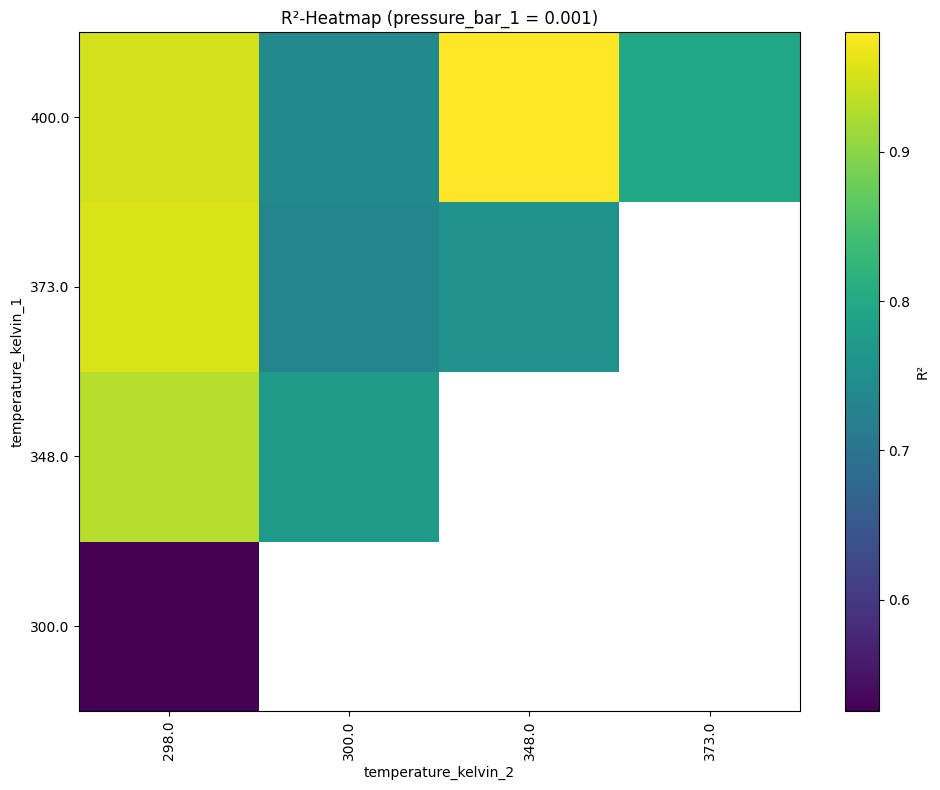

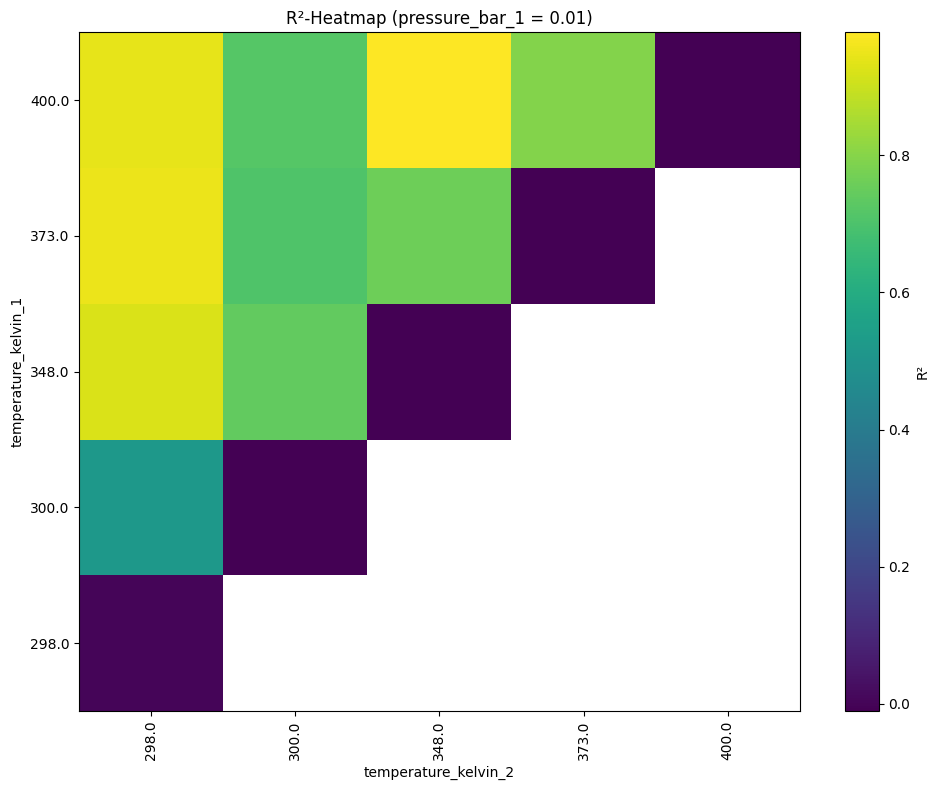

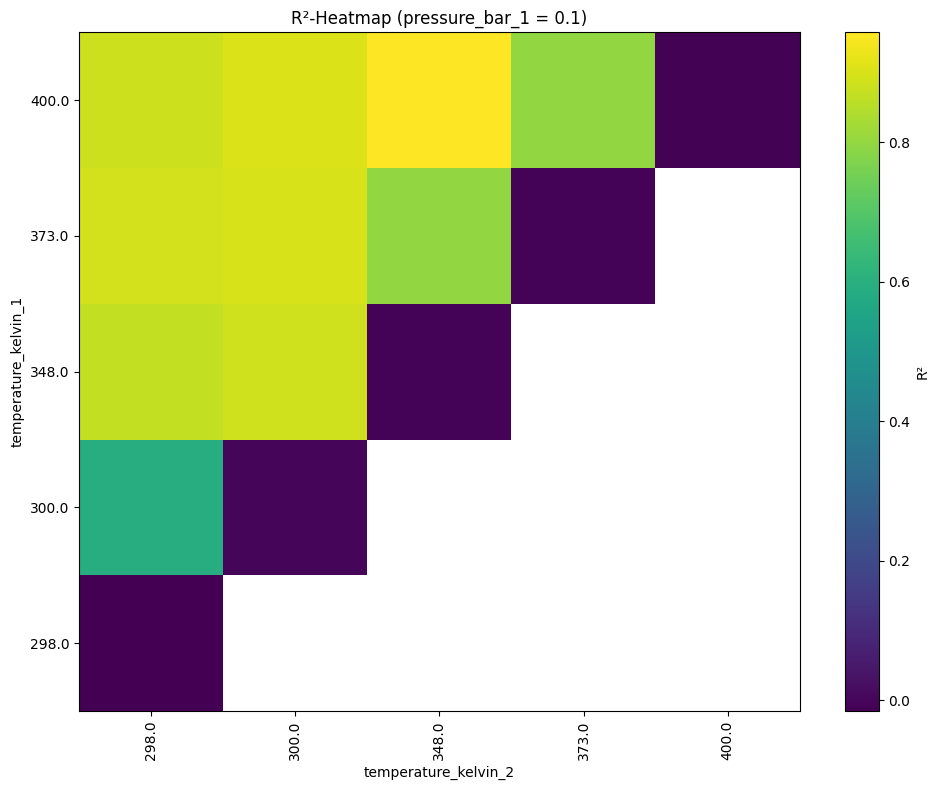

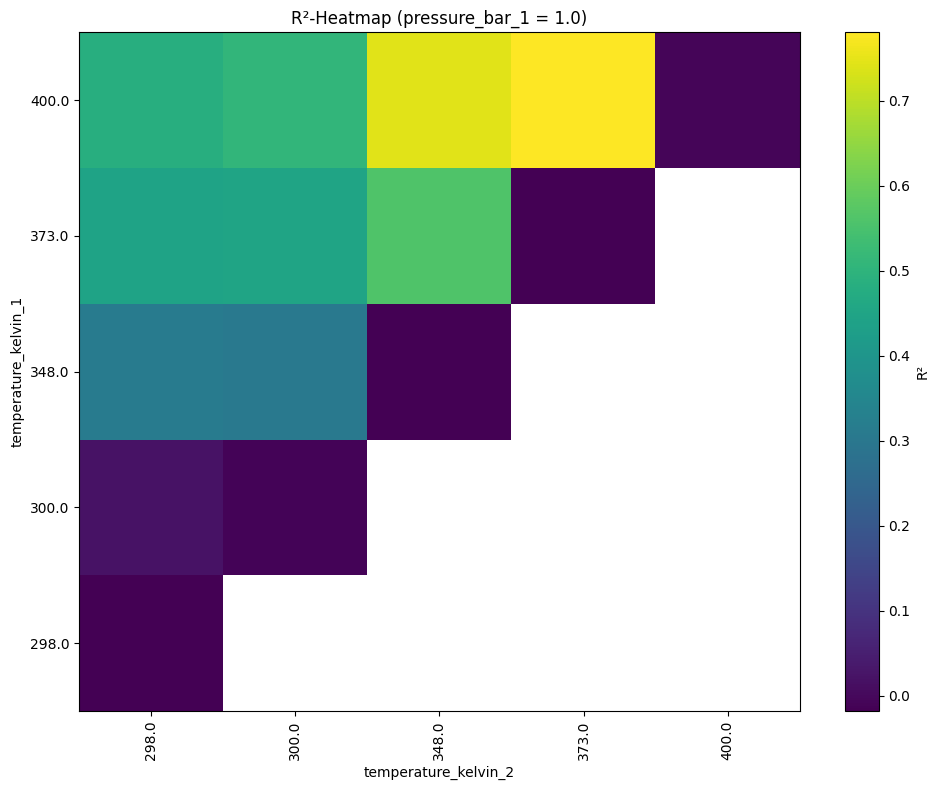

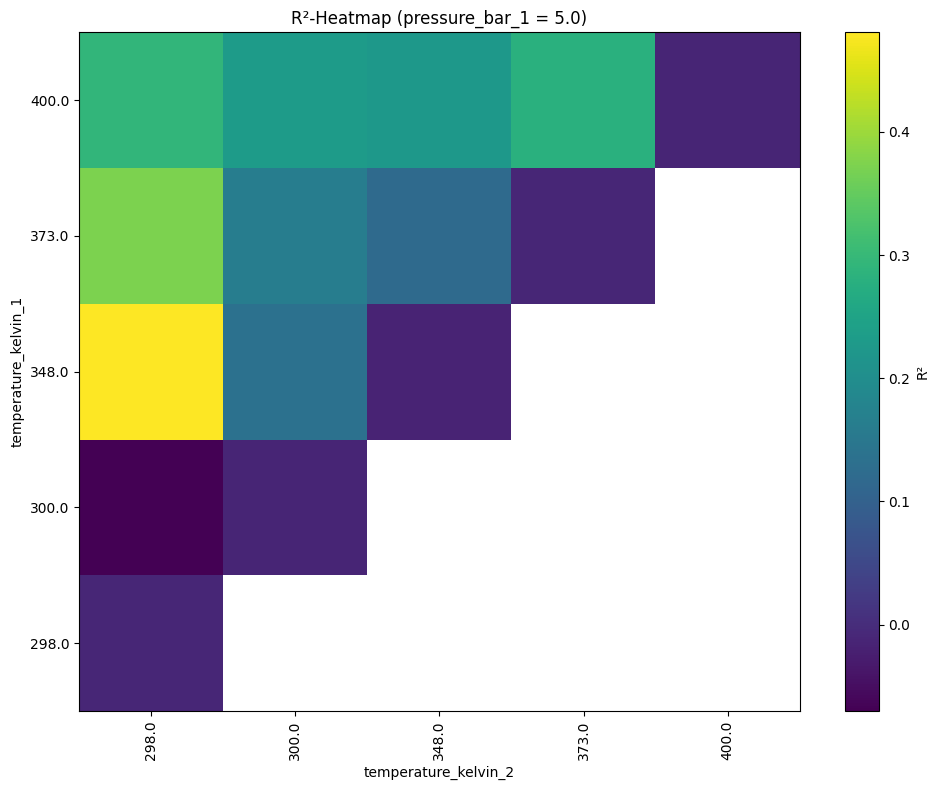

In [16]:
pressures = np.sort(doto["pressure_bar_1"].unique())

for p in pressures:
    # 2) Nicht das Original-DF überschreiben; Subset je Druck bauen
    sub = doto[doto["pressure_bar_1"].eq(p)]

    if sub.empty:
        continue  # falls numerische Toleranzen o.ä.

    # 3) Pivot-Table (optional: Mittelwert bei Duplikaten)
    heatmap_data = sub.pivot_table(
        index="temperature_kelvin_1",
        columns="temperature_kelvin_2",
        values="r2",
        aggfunc="mean"
    )

    # Optional: sortierte Achsen (macht die Heatmap „ordentlicher“)
    heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

    # 4) Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_data.values, aspect='auto', origin='lower')
    plt.colorbar(label='R²')

    plt.title(f"R²-Heatmap (pressure_bar_1 = {p})")
    plt.xlabel("temperature_kelvin_2")
    plt.ylabel("temperature_kelvin_1")

    # Achsen-Ticks passend zu den DataFrame-Achsen setzen
    plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
    plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

    plt.tight_layout()
    plt.show()

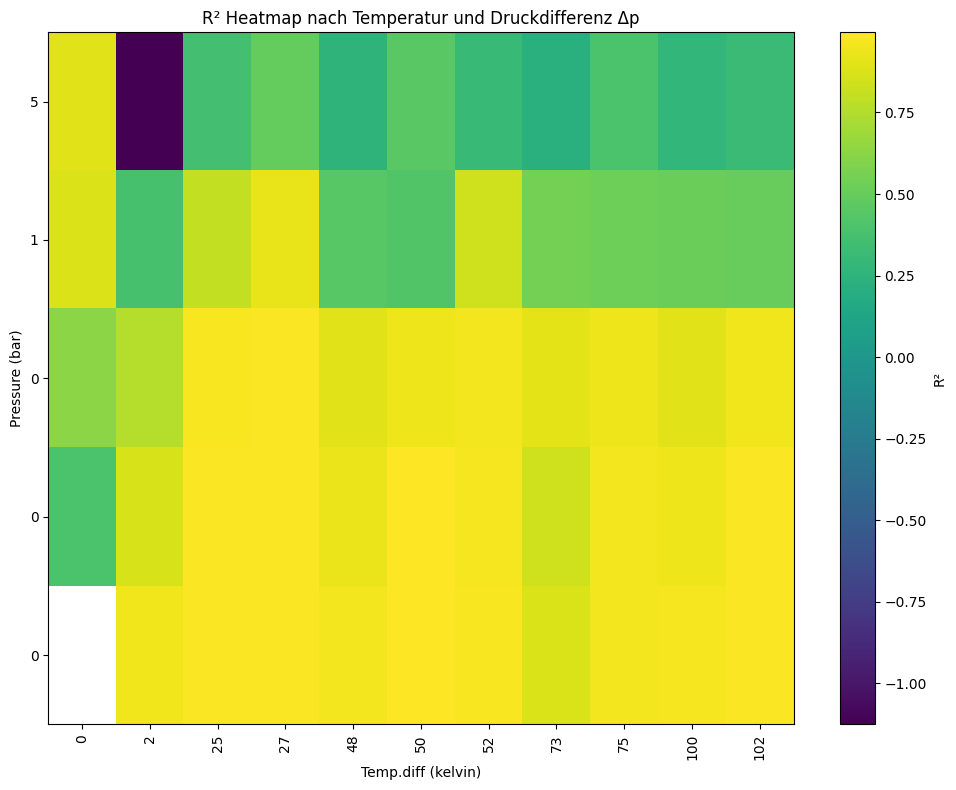

In [4]:
doto["delta_t"] = (doto["temperature_kelvin_2"] - doto["temperature_kelvin_1"]).abs()

# --- Pivot-Tabelle: Temperatur vs Δp ---
heatmap_data = doto.pivot_table(
    index="pressure_bar_1",   # Y-Achse
    columns="delta_t",            # X-Achse
    values="r2",                  # Farbe repräsentiert R²
    aggfunc="mean"                # Mittelwert, falls mehrere Kombinationen
)

# --- Sortierung (optional, für saubere Achsen) ---
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(im, label="R²")

plt.title("R² Heatmap nach Temperatur und Druckdifferenz Δp")
plt.xlabel("Temp.diff (kelvin)")
plt.ylabel("Pressure (bar)")

# Achsenbeschriftungen mit tatsächlichen Werten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns.astype(int), rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index.astype(int))

plt.tight_layout()
plt.show()

In [5]:
data=data[data["found_global_best"]==True]

In [6]:
data

,timestamp,temperature_kelvin_T1,temperature_kelvin_T2,pressure_bar_1,pressure_bar_2,n_candidates,n_iterations,best_value,global_best_value,found_global_best
0,2025-11-27T18:22:24,300.0,298.0,0.001,0.001,245,32,208.433589,208.433589,True
1,2025-11-27T18:22:31,348.0,298.0,0.001,0.001,245,23,2143.754884,2143.754884,True
2,2025-11-27T18:22:40,348.0,300.0,0.001,0.001,245,27,1935.321295,1935.321295,True
3,2025-11-27T18:22:47,373.0,298.0,0.001,0.001,245,24,2358.670196,2358.670196,True
4,2025-11-27T18:22:55,373.0,300.0,0.001,0.001,245,25,2150.236607,2150.236607,True
...,...,...,...,...,...,...,...,...,...,...
95,2025-11-27T18:34:38,400.0,400.0,1.000,0.100,245,18,44.025414,44.025414,True
96,2025-11-27T18:34:46,400.0,400.0,5.000,0.001,245,25,90.228944,90.228944,True
97,2025-11-27T18:34:54,400.0,400.0,5.000,0.010,245,23,89.631803,89.631803,True
98,2025-11-27T18:35:03,400.0,400.0,5.000,0.100,245,27,83.582114,83.582114,True


In [7]:
doto

,run_started_at,timestamp,temperature_kelvin_1,temperature_kelvin_2,pressure_bar_1,pressure_bar_2,n_rows,r2,median_APE_pct,mean_APE_pct,count_APE_gt_20pct,max_APE_pct,folds,delta_t
0,2025-11-27T18:22:14,2025-11-27T18:22:19,300.0,298.0,0.001,0.001,245,0.948154,6.434849,2.342827e+07,56,5.739906e+09,"1,2,3,4,5,6,7,8,9,10",2.0
1,2025-11-27T18:22:14,2025-11-27T18:22:28,348.0,298.0,0.001,0.001,245,0.995825,5.751572,7.495722e+06,41,1.834653e+09,"1,2,3,4,5,6,7,8,9,10",50.0
2,2025-11-27T18:22:14,2025-11-27T18:22:35,348.0,300.0,0.001,0.001,245,0.959876,6.102823,4.205104e+09,42,1.029328e+12,"1,2,3,4,5,6,7,8,9,10",48.0
3,2025-11-27T18:22:14,2025-11-27T18:22:44,373.0,298.0,0.001,0.001,245,0.961975,3.976042,7.962909e+09,30,1.950247e+12,"1,2,3,4,5,6,7,8,9,10",75.0
4,2025-11-27T18:22:14,2025-11-27T18:22:51,373.0,300.0,0.001,0.001,245,0.874372,4.749884,4.942700e+09,33,1.210443e+12,"1,2,3,4,5,6,7,8,9,10",73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-11-27T18:22:14,2025-11-27T18:34:35,400.0,400.0,1.000,0.100,245,0.873351,38.398492,6.386852e+05,178,1.558577e+08,"1,2,3,4,5,6,7,8,9,10",0.0
96,2025-11-27T18:22:14,2025-11-27T18:34:42,400.0,400.0,5.000,0.001,245,0.949138,21.946931,1.902835e+06,130,3.751703e+08,"1,2,3,4,5,6,7,8,9,10",0.0
97,2025-11-27T18:22:14,2025-11-27T18:34:50,400.0,400.0,5.000,0.010,245,0.950350,22.789426,8.907868e+04,134,2.173768e+07,"1,2,3,4,5,6,7,8,9,10",0.0
98,2025-11-27T18:22:14,2025-11-27T18:34:58,400.0,400.0,5.000,0.100,245,0.939637,20.648523,1.247030e+06,128,3.054511e+08,"1,2,3,4,5,6,7,8,9,10",0.0


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------------
# 1. Zielzustände definieren
# ---------------------------------------------------------
target_states = [
    {"T1": 400.0, "T2": 298.0, "p1": 1.0,   "p2": 1.0},
    {"T1": 298.0, "T2": 298.0, "p1": 5.0,   "p2": 1.0},
    {"T1": 298.0, "T2": 298.0, "p1": 1, "p2": 0.001},
]

# ---------------------------------------------------------
# 2. Daten laden
# ---------------------------------------------------------
data = pd.read_csv("logs/bo_runs_data_swing_Vext_densB_addfeatchem.csv")

# Vereinheitlichen, falls floats leicht variieren
for col in ["pressure_bar_1", "pressure_bar_2", "temperature_kelvin_T1", "temperature_kelvin_T2"]:
    data[col] = data[col].astype(float)

# ---------------------------------------------------------
# 3. Nur target states extrahieren
# ---------------------------------------------------------
rows = []
for state in target_states:
    mask = (
        (data["temperature_kelvin_T1"] == state["T1"]) &
        (data["temperature_kelvin_T2"] == state["T2"]) &
        (data["pressure_bar_1"]        == state["p1"]) &
        (data["pressure_bar_2"]        == state["p2"])
    )
    rows.append(data[mask])

filtered = pd.concat(rows, ignore_index=True)

print("Anzahl gefundener target rows:", len(filtered))
print(filtered[["temperature_kelvin_T1","temperature_kelvin_T2","pressure_bar_1","pressure_bar_2","found_global_best"]])
print()

# ---------------------------------------------------------
# 4. Heatmap für jedes target state bauen
# ---------------------------------------------------------
for state in target_states:

    T1 = state["T1"]
    T2 = state["T2"]
    p1 = state["p1"]
    p2 = state["p2"]

    state_df = filtered[
        (filtered["temperature_kelvin_T1"] == T1) &
        (filtered["temperature_kelvin_T2"] == T2) &
        (filtered["pressure_bar_1"] == p1) &
        (filtered["pressure_bar_2"] == p2)
    ]

    if state_df.empty:
        print(f"Keine Daten für State: {state}")
        continue

    # -----------------------------------------------------
    # Heatmap-Daten (1×1 Matrix) + Markierungen
    # -----------------------------------------------------
    r2_val = state_df["r2"].mean()
    found = bool(state_df["found_global_best"].max())

    heatmap_matrix = np.array([[r2_val]])

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(heatmap_matrix, cmap="viridis", vmin=0, vmax=1)

    plt.title(f"R² für State\nT1={T1}, T2={T2}, p1={p1}, p2={p2}")
    plt.colorbar(label="R²")
    plt.xticks([0], [f"T2={T2}"])
    plt.yticks([0], [f"T1={T1}"])

    # -----------------------------------------------------
    # Markieren, wenn found_global_best == True
    # -----------------------------------------------------
    if found:
        # Option A: roter Rahmen
        plt.gca().add_patch(
            plt.Rectangle(
                (0 - 0.5, 0 - 0.5), 1, 1,
                fill=False, edgecolor="red", linewidth=3
            )
        )

        # Option B: Symbol in der Zelle (✓ oder ✸)
        plt.text(
            0, 0, "✓",
            ha="center", va="center",
            fontsize=32, color="red"
        )

    plt.tight_layout()
    plt.show()


Anzahl gefundener target rows: 4
   temperature_kelvin_T1  temperature_kelvin_T2  pressure_bar_1  \
0                  400.0                  298.0             1.0   
1                  400.0                  298.0             1.0   
2                  298.0                  298.0             5.0   
3                  298.0                  298.0             1.0   

   pressure_bar_2  found_global_best  
0           1.000               True  
1           1.000               True  
2           1.000              False  
3           0.001               True  



KeyError: 'r2'